## Machine Learning & AI

![Colegio Bourbaki](./Images/Bourbaki.png)

### Introducción a Doc2Vec y Pytorch

Doc2vec desde cero en PyTorch

 Todo esto está basado en el gran trabajo de [Nejc Ilenic](https://github.com/inejc/paragraph-vectors) y el código fuente de gensim.

`doc2vec` desciende de `word2vec`, cuya forma básica es que es un modelo entrenado para predecir la palabra que falta en un contexto. Dadas frases como "el gato ___ en la alfombra" debería predecir "se sentó", y al hacerlo aprende una representación útil de las palabras. A continuación, podemos extraer las ponderaciones internas y reutilizarlas como "incrustaciones o encajes de palabras", vectores que dan a cada palabra una posición en un espacio de N dimensiones que se espera que esté cerca de palabras similares y a una distancia adecuada de las palabras relacionadas. 

Doc2vec" o "vectores de párrafo" amplía la idea de "word2vec" añadiendo un identificador de documento a cada contexto. Esto ayuda a la red a aprender asociaciones entre contextos y produce vectores que posicionan cada párrafo (documento) en el espacio.

Primero tenemos que cargar los datos. Empezaremos sobreajustando un pequeño conjunto de datos para comprobar que todas las piezas encajan.

In [3]:
import pandas as pd
import spacy

nlp = spacy.load("en_core_web_sm")

pd.set_option("display.max_colwidth", 100)

example_df = pd.read_csv("./Data/example.csv")

def tokenize_text(df):
    df["tokens"] = df.text.str.lower().str.strip().apply(lambda x: [token.text.strip() for token in nlp(x) if token.text.isalnum()])
    return df

example_df = tokenize_text(example_df)

example_df

,text,tokens
0,"In the week before their departure to Arrakis, when all the final scurrying about had reached a ...","[in, the, week, before, their, departure, to, arrakis, when, all, the, final, scurrying, about, ..."
1,"It was a warm night at Castle Caladan, and the ancient pile of stone that had served the Atreide...","[it, was, a, warm, night, at, castle, caladan, and, the, ancient, pile, of, stone, that, had, se..."
2,The old woman was let in by the side door down the vaulted passage by Paul's room and she was al...,"[the, old, woman, was, let, in, by, the, side, door, down, the, vaulted, passage, by, paul, room..."
3,"By the half-light of a suspensor lamp, dimmed and hanging near the floor, the awakened boy could...","[by, the, half, light, of, a, suspensor, lamp, dimmed, and, hanging, near, the, floor, the, awak..."


Construiremos un vocabulario para poder referenciar cada palabra por un ID:

In [2]:
from collections import Counter

class Vocab:
    def __init__(self, all_tokens, min_count=2):
        self.min_count = min_count
        self.freqs = {t:n for t, n in Counter(all_tokens).items() if n >= min_count}
        self.words = sorted(self.freqs.keys())
        self.word2idx = {w: i for i, w in enumerate(self.words)}
        
vocab = Vocab([tok for tokens in example_df.tokens for tok in tokens], min_count=1)

print(f"Dataset comprises {len(example_df)} documents and {len(vocab.words)} unique words (over the limit of {vocab.min_count} occurrences)")

Dataset comprises 4 documents and 106 unique words (over the limit of 1 occurrences)


In [6]:
vocab.word2idx

{'a': 0,
 'about': 1,
 'acquired': 2,
 'ahead': 3,
 'all': 4,
 'allowed': 5,
 'an': 6,
 'ancient': 7,
 'and': 8,
 'arrakis': 9,
 'as': 10,
 'at': 11,
 'atreides': 12,
 'awakened': 13,
 'bed': 14,
 'before': 15,
 'bore': 16,
 'boy': 17,
 'bulky': 18,
 'by': 19,
 'caladan': 20,
 'came': 21,
 'castle': 22,
 'change': 23,
 'cooled': 24,
 'could': 25,
 'crone': 26,
 'darkness': 27,
 'departure': 28,
 'dimmed': 29,
 'door': 30,
 'down': 31,
 'eyes': 32,
 'family': 33,
 'features': 34,
 'feeling': 35,
 'female': 36,
 'final': 37,
 'floor': 38,
 'for': 39,
 'frenzy': 40,
 'generations': 41,
 'glittering': 42,
 'had': 43,
 'hair': 44,
 'half': 45,
 'hanging': 46,
 'he': 47,
 'him': 48,
 'his': 49,
 'home': 50,
 'hooded': 51,
 'in': 52,
 'it': 53,
 'jewels': 54,
 'lamp': 55,
 'lay': 56,
 'let': 57,
 'light': 58,
 'like': 59,
 'matted': 60,
 'moment': 61,
 'mother': 62,
 'near': 63,
 'nearly': 64,
 'night': 65,
 'of': 66,
 'old': 67,
 'one': 68,
 'passage': 69,
 'paul': 70,
 'peer': 71,
 'pile': 

Las palabras que aparecen muy raramente pueden perjudicar el rendimiento, por lo que añadimos un mecanismo sencillo para eliminarlas.

In [7]:
def clean_tokens(df, vocab):
    df["length"] = df.tokens.apply(len)
    df["clean_tokens"] = df.tokens.apply(lambda x: [t for t in x if t in vocab.freqs.keys()])
    df["clean_length"] = df.clean_tokens.apply(len)
    return df

example_df = clean_tokens(example_df, vocab)
example_df[:]

,text,tokens,length,clean_tokens,clean_length
0,"In the week before their departure to Arrakis, when all the final scurrying about had reached a ...","[in, the, week, before, their, departure, to, arrakis, when, all, the, final, scurrying, about, ...",32,"[in, the, week, before, their, departure, to, arrakis, when, all, the, final, scurrying, about, ...",32
1,"It was a warm night at Castle Caladan, and the ancient pile of stone that had served the Atreide...","[it, was, a, warm, night, at, castle, caladan, and, the, ancient, pile, of, stone, that, had, se...",39,"[it, was, a, warm, night, at, castle, caladan, and, the, ancient, pile, of, stone, that, had, se...",39
2,The old woman was let in by the side door down the vaulted passage by Paul's room and she was al...,"[the, old, woman, was, let, in, by, the, side, door, down, the, vaulted, passage, by, paul, room...",34,"[the, old, woman, was, let, in, by, the, side, door, down, the, vaulted, passage, by, paul, room...",34
3,"By the half-light of a suspensor lamp, dimmed and hanging near the floor, the awakened boy could...","[by, the, half, light, of, a, suspensor, lamp, dimmed, and, hanging, near, the, floor, the, awak...",53,"[by, the, half, light, of, a, suspensor, lamp, dimmed, and, hanging, near, the, floor, the, awak...",53


La dificultad de nuestro problema "el gato _ en la alfombra" es que la palabra que falta podría ser cualquiera del vocabulario V y, por tanto, la red tendría salidas |V| para cada entrada, por ejemplo, un enorme vector con cero para cada palabra del vocabulario y algún número positivo para "sat" si la red estuviera perfectamente entrenada. Para calcular la pérdida, tenemos que convertirlo en una distribución de probabilidad, es decir, en un "softmax". Calcular el softmax para un vector tan grande es costoso.

Así que el truco (uno de los muchos posibles) que utilizaremos es la Estimación Contrastiva de Ruido (NCE). Cambiamos nuestro problema "el gato ___ en la alfombra" por un problema de elección múltiple, pidiendo a la red que elija entre "se sentó" y algunas respuestas erróneas aleatorias como "rayuela" y "se deleitó". Esto es más fácil de calcular porque ahora es un clasificador binario (respuesta correcta o incorrecta) y la salida es simplemente un vector de tamaño 1 + k, donde k es el número de opciones incorrectas aleatorias.

Afortunadamente, este problema alternativo sigue aprendiendo representaciones de palabras igualmente útiles. Sólo tenemos que ajustar los ejemplos y la función de pérdida. Existe una versión simplificada de la función de pérdida NCE llamada Muestreo Negativo (NEG) que podemos utilizar aquí.

Cuando aplicamos la función de pérdida, suponemos que el primer elemento de un vector muestras/puntuaciones es la puntuación de la muestra positiva y el resto son muestras negativas. Esta convención nos evita tener que pasar un vector auxiliar que indique qué muestra fue positiva.

In [ ]:
!pip install pandas spacy torch torchvision torchaudio

In [8]:
import torch.nn as nn

class NegativeSampling(nn.Module):
    def __init__(self):
        super(NegativeSampling, self).__init__()
        self.log_sigmoid = nn.LogSigmoid()
    def forward(self, scores):
        batch_size = scores.shape[0]
        n_negative_samples = scores.shape[1] - 1   # TODO average or sum the negative samples? Summing seems to be correct by the paper
        positive = self.log_sigmoid(scores[:,0])
        negatives = torch.sum(self.log_sigmoid(-scores[:,1:]), dim=1)
        return -torch.sum(positive + negatives) / batch_size  # average for batch

loss = NegativeSampling()

Es útil jugar con algunos valores para asegurarnos de que esta función hace lo correcto:

In [9]:
import torch 

data = [[[1, -1, -1, -1]],  # this dummy data uses -1 to 1, but the real model is unconstrained
        [[0.5, -1, -1, -1]],
        [[0, -1, -1, -1]],
        [[0, 0, 0, 0]],
        [[0, 0, 0, 1]],
        [[0, 1, 1, 1]],
        [[0.5, 1, 1, 1]],
        [[1, 1, 1, 1]]]

loss_df = pd.DataFrame(data, columns=["scores"])
loss_df["loss"] = loss_df.scores.apply(lambda x: loss(torch.FloatTensor([x])))

loss_df

,scores,loss
0,"[1, -1, -1, -1]",tensor(1.2530)
1,"[0.5, -1, -1, -1]",tensor(1.4139)
2,"[0, -1, -1, -1]",tensor(1.6329)
3,"[0, 0, 0, 0]",tensor(2.7726)
4,"[0, 0, 0, 1]",tensor(3.3927)
5,"[0, 1, 1, 1]",tensor(4.6329)
6,"[0.5, 1, 1, 1]",tensor(4.4139)
7,"[1, 1, 1, 1]",tensor(4.2530)


Las puntuaciones más altas de la muestra positiva (siempre el primer elemento) reducen la pérdida, pero las puntuaciones más altas de las muestras negativas aumentan la pérdida. Este parece el comportamiento correcto.

Con esto en la mochila, veamos cómo crear datos de entrenamiento. La idea general es crear un conjunto de ejemplos donde cada ejemplo tiene:

- doc id
- ids de muestra - una colección del token objetivo y algunos tokens de ruido
- ids de contexto - tokens antes y después del token objetivo

Por ejemplo, si el tamaño de nuestro contexto fuera 2, el primer ejemplo del conjunto de datos anterior sería:

```
{"doc_id": 0,
 "sample_ids": [word2idx[x] for x in ["semana", "palabra-aleatoria-de-vocab", "palabra-aleatoria-de-vocab"...],
 "context_ids": [word2idx[x] for x in ["en", "el", "antes", "sus"]]}
 ```
 
 Las palabras aleatorias se eligen según una distribución de probabilidad:
 
 > una distribución de unigramas elevada a la 3/4ª potencia, como proponen T. Mikolov et al. en Distributed Representations of Words and Phrases and their Compositionality.

Esto tiene el efecto de aumentar ligeramente la probabilidad relativa de las palabras raras (mire el gráfico de `y=x^0,75` más abajo y vea cómo el extremo inferior se eleva por encima de `y=x`).

In [10]:
import altair as alt
import numpy as np

data = pd.DataFrame(zip(np.arange(0,1,0.01), np.power(np.arange(0,1,0.01), 0.75)), columns=["x", "y"])
alt.Chart(data, title="x^0.75").mark_line().encode(x="x", y="y")

alt.Chart(...)

In [11]:
import numpy as np

class NoiseDistribution:
    def __init__(self, vocab):
        self.probs = np.array([vocab.freqs[w] for w in vocab.words])
        self.probs = np.power(self.probs, 0.75)
        self.probs /= np.sum(self.probs)
    def sample(self, n):
        "Returns the indices of n words randomly sampled from the vocabulary."
        return np.random.choice(a=self.probs.shape[0], size=n, p=self.probs)
        
noise = NoiseDistribution(vocab)

Con esta distribución, avanzamos por los documentos creando ejemplos. Tengamos en cuenta que siempre ponemos la muestra positiva en primer lugar en el vector de muestras, siguiendo la convención que espera la función de pérdida.

In [12]:
import torch

def example_generator(df, context_size, noise, n_negative_samples, vocab):
    for doc_id, doc in df.iterrows():
        for i in range(context_size, len(doc.clean_tokens) - context_size):
            positive_sample = vocab.word2idx[doc.clean_tokens[i]]
            sample_ids = noise.sample(n_negative_samples).tolist()
            # Fix a wee bug - ensure negative samples don't accidentally include the positive
            sample_ids = [sample_id if sample_id != positive_sample else -1 for sample_id in sample_ids]
            sample_ids.insert(0, positive_sample)                
            context = doc.clean_tokens[i - context_size:i] + doc.clean_tokens[i + 1:i + context_size + 1]
            context_ids = [vocab.word2idx[w] for w in context]
            yield {"doc_ids": torch.tensor(doc_id),  # we use plural here because it will be batched
                   "sample_ids": torch.tensor(sample_ids), 
                   "context_ids": torch.tensor(context_ids)}
            
examples = example_generator(example_df, context_size=5, noise=noise, n_negative_samples=5, vocab=vocab)

Ahora lo empaquetamos como un dataset y dataloader de PyTorch.

In [17]:
from torch.utils.data import Dataset, DataLoader

class NCEDataset(Dataset):
    def __init__(self, examples):
        self.examples = list(examples)  # just naively evaluate the whole damn thing - suboptimal!
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, index):
        return self.examples[index]
    
dataset = NCEDataset(examples)
dataloader = DataLoader(dataset, batch_size=2, drop_last=True, shuffle=True)  # TODO bigger batch size when not dummy data

También va a ser útil tener una manera de convertir los lotes de nuevo a una forma legible para la depuración, por lo que añadimos una función de ayuda.

In [18]:
def describe_batch(batch, vocab):
    results = []
    for doc_id, context_ids, sample_ids in zip(batch["doc_ids"], batch["context_ids"], batch["sample_ids"]):
        context = [vocab.words[i] for i in context_ids]
        context.insert(len(context_ids) // 2, "____")
        samples = [vocab.words[i] for i in sample_ids]
        result = {"doc_id": doc_id,
                  "context": " ".join(context), 
                  "context_ids": context_ids, 
                  "samples": samples, 'samples': ['served', 'home', 'lamp', 'was', 'let', 'of'],
                  "sample_ids": sample_ids}
        results.append(result)
    return results

describe_batch(next(iter(dataloader)), vocab)

[{'doc_id': tensor(3),
  'context': 'could see a bulky female ____ at his door standing one',
  'context_ids': tensor([25, 77,  0, 18, 36, 11, 49, 30, 85, 68]),
  'samples': ['served', 'home', 'lamp', 'was', 'let', 'of'],
  'sample_ids': tensor([80, 46, 57, 65, 18, 48])},
 {'doc_id': tensor(3),
  'context': 'his door standing one step ____ of his mother the old',
  'context_ids': tensor([49, 30, 85, 68, 86, 66, 49, 62, 91, 67]),
  'samples': ['served', 'home', 'lamp', 'was', 'let', 'of'],
  'sample_ids': tensor([ 3,  8, 63,  6, 22, 91])}]

Pasemos a crear el modelo en sí. No hay mucho que hacer - multiplicamos las matrices de entrada de párrafos y palabras por la capa de salida. La combinación de las matrices de párrafos y palabras se hace sumando aquí, pero también podría hacerse concatenando las entradas. En el artículo original se descubrió que la concatenación funciona mejor, quizá porque al sumar se pierde información sobre el orden de las palabras.

In [19]:
import torch.nn as nn

class DistributedMemory(nn.Module):
    def __init__(self, vec_dim, n_docs, n_words):
        super(DistributedMemory, self).__init__()
        self.paragraph_matrix = nn.Parameter(torch.randn(n_docs, vec_dim))
        self.word_matrix = nn.Parameter(torch.randn(n_words, vec_dim))
        self.outputs = nn.Parameter(torch.zeros(vec_dim, n_words))
    
    def forward(self, doc_ids, context_ids, sample_ids):
                                                                               # first add doc ids to context word ids to make the inputs
        inputs = torch.add(self.paragraph_matrix[doc_ids,:],                   # (batch_size, vec_dim)
                           torch.sum(self.word_matrix[context_ids,:], dim=1))  # (batch_size, 2x context, vec_dim) -> sum to (batch_size, vec_dim)
                                                                               #
        #inputs = torch.cat(self.paragraph_matrix[doc_ids,:],                   # (batch_size, vec_dim)                                                                       # select the subset of the output layer for the NCE test
        outputs = self.outputs[:,sample_ids]                                   # (vec_dim, batch_size, n_negative_samples + 1)
                                                                               #
        return torch.bmm(inputs.unsqueeze(dim=1),                              # then multiply with some munging to make the tensor shapes line up 
                         outputs.permute(1, 0, 2)).squeeze()                   # -> (batch_size, n_negative_samples + 1)

model = DistributedMemory(vec_dim=50,
                          n_docs=len(example_df),
                          n_words=len(vocab.words))

Veamos:

In [20]:
with torch.no_grad():
    logits = model.forward(**next(iter(dataloader)))
logits

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

La capa de salida se inicializó con ceros. Es hora de hacer un bucle de entrenamiento estándar de PyTorch.

In [21]:
from tqdm import tqdm, trange
from torch.optim import Adam  # ilenic uses Adam, but gensim uses plain SGD
import numpy as np

def train(model, dataloader, epochs=40, lr=1e-3):
    optimizer = Adam(model.parameters(), lr=lr)
    training_losses = []
    try:
        for epoch in trange(epochs, desc="Epochs"):
            epoch_losses = []
            for batch in dataloader:
                model.zero_grad()
                logits = model.forward(**batch)
                batch_loss = loss(logits)
                epoch_losses.append(batch_loss.item())
                batch_loss.backward()
                optimizer.step()
            training_losses.append(np.mean(epoch_losses))
    except KeyboardInterrupt:
        print(f"Interrupted on epoch {epoch}!")
    finally:
        return training_losses

Ahora comprobaremos la integridad sobreajustando los datos de ejemplo. La pérdida de entrenamiento debería caer desde la pérdida no entrenada hasta algo cercano al mínimo posible.

In [22]:
training_losses = train(model, dataloader, epochs=40, lr=1e-3)

Epochs: 100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


In [23]:
import altair as alt

df_loss = pd.DataFrame(enumerate(training_losses), columns=["epoch", "training_loss"])
alt.Chart(df_loss).mark_bar().encode(alt.X("epoch"), alt.Y("training_loss", scale=alt.Scale(type="log")))

alt.Chart(...)

<Axes: >

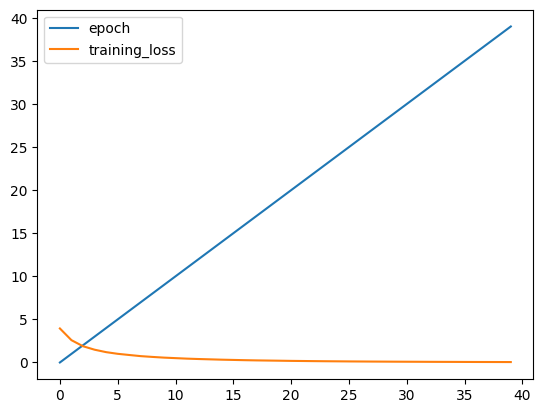

In [25]:
df_loss.plot()  

And because we're paranoid types, let's check a prediction.

In [26]:
with torch.no_grad():
    logits = model.forward(**next(iter(dataloader)))
logits

tensor([[ 5.9023, -6.7047, -6.2654, -6.7725, -7.2265, -3.0456],
        [ 5.1143, -5.3032, -7.3133, -8.4777, -6.1268, -6.1874]])

La muestra positiva obtiene una puntuación positiva y las negativas, una puntuación negativa.

Deberíamos poder obtener los vectores de párrafo de los documentos y hacer cosas como comprobar la similitud entre ellos.

In [27]:
from sklearn.preprocessing import normalize

def most_similar(paragraph_matrix, docs_df, index, n=None):
    pm = normalize(paragraph_matrix, norm="l2")  # in a smarter implementation we would cache this somewhere
    sims = np.dot(pm, pm[index,:])
    df = pd.DataFrame(enumerate(sims), columns=["doc_id", "similarity"])
    n = n if n is not None else len(sims)
    return df.merge(docs_df[["text"]].reset_index(drop=True), left_index=True, right_index=True).sort_values(by="similarity", ascending=False)[:n]

most_similar(model.paragraph_matrix.data, example_df, 1, n=10)

,doc_id,similarity,text
1,1,1.000000,"It was a warm night at Castle Caladan, and the ancient pile of stone that had served the Atreide..."
3,3,0.208677,"By the half-light of a suspensor lamp, dimmed and hanging near the floor, the awakened boy could..."
2,2,0.139703,The old woman was let in by the side door down the vaulted passage by Paul's room and she was al...
0,0,-0.033162,"In the week before their departure to Arrakis, when all the final scurrying about had reached a ..."


Sin embargo, no es especialmente esclarecedor para nuestro pequeño conjunto de datos ficticios. También podemos utilizar PCA para reducir nuestros vectores de párrafos n-dimensionales a 2 dimensiones y ver si se agrupan bien.

In [28]:
from sklearn.decomposition import PCA

def pca_2d(paragraph_matrix, groups):
    pca = PCA(n_components=2)
    reduced_dims = pca.fit_transform(paragraph_matrix)
    print(f"2-component PCA, explains {sum(pca.explained_variance_):.2f}% of variance")
    df = pd.DataFrame(reduced_dims, columns=["x", "y"])
    df["group"] = groups
    return df

example_2d = pca_2d(model.paragraph_matrix.data, ["0","1","2","3"])
alt.Chart(example_2d).mark_point().encode(x="x", y="y", color="group")

2-component PCA, explains 41.33% of variance


alt.Chart(...)

No hay mucho que ver en un conjunto de datos tan pequeño sin grupos etiquetados.

Ejecutando esto en algunos datos más grandes, utilizaremos el conjunto de datos de la BBC.

In [29]:
dfs = []
for document_set in ("sport",
                     "business",
                     "politics", 
                     "tech", 
                     "entertainment"):
    df_ = pd.read_csv(f"./Data/bbc/{document_set}.csv.bz2", encoding="latin1")
    df_ = tokenize_text(df_)
    df_["group"] = document_set
    dfs.append(df_)

bbc_df = pd.concat(dfs)
bbc_df[:4]

,text,tokens,group
0,Claxton hunting first major medal British hurdler Sarah Claxton is confident she can win her fi...,"[claxton, hunting, first, major, medal, british, hurdler, sarah, claxton, is, confident, she, ca...",sport
1,O'Sullivan could run in Worlds Sonia O'Sullivan has indicated that she would like to participat...,"[could, run, in, worlds, sonia, has, indicated, that, she, would, like, to, participate, in, nex...",sport
2,Greene sets sights on world title Maurice Greene aims to wipe out the pain of losing his Olympi...,"[greene, sets, sights, on, world, title, maurice, greene, aims, to, wipe, out, the, pain, of, lo...",sport
3,IAAF launches fight against drugs The IAAF - athletics' world governing body - has met anti-dop...,"[iaaf, launches, fight, against, drugs, the, iaaf, athletics, world, governing, body, has, met, ...",sport


In [30]:
bbc_df[:10]

,text,tokens,group
0,Claxton hunting first major medal British hurdler Sarah Claxton is confident she can win her fi...,"[claxton, hunting, first, major, medal, british, hurdler, sarah, claxton, is, confident, she, ca...",sport
1,O'Sullivan could run in Worlds Sonia O'Sullivan has indicated that she would like to participat...,"[could, run, in, worlds, sonia, has, indicated, that, she, would, like, to, participate, in, nex...",sport
2,Greene sets sights on world title Maurice Greene aims to wipe out the pain of losing his Olympi...,"[greene, sets, sights, on, world, title, maurice, greene, aims, to, wipe, out, the, pain, of, lo...",sport
3,IAAF launches fight against drugs The IAAF - athletics' world governing body - has met anti-dop...,"[iaaf, launches, fight, against, drugs, the, iaaf, athletics, world, governing, body, has, met, ...",sport
4,"Dibaba breaks 5,000m world record Ethiopia's Tirunesh Dibaba set a new world record in winning ...","[dibaba, breaks, m, world, record, ethiopia, tirunesh, dibaba, set, a, new, world, record, in, w...",sport
5,Isinbayeva claims new world best Pole vaulter Yelena Isinbayeva broke her own indoor world reco...,"[isinbayeva, claims, new, world, best, pole, vaulter, yelena, isinbayeva, broke, her, own, indoo...",sport
6,O'Sullivan commits to Dublin race Sonia O'Sullivan will seek to regain her title at the Bupa Gr...,"[commits, to, dublin, race, sonia, will, seek, to, regain, her, title, at, the, bupa, great, ire...",sport
7,Hansen 'delays return until 2006' British triple jumper Ashia Hansen has ruled out a comeback t...,"[hansen, delays, return, until, 2006, british, triple, jumper, ashia, hansen, has, ruled, out, a...",sport
8,Off-colour Gardener storms to win Britain's Jason Gardener shook off an upset stomach to win th...,"[off, colour, gardener, storms, to, win, britain, jason, gardener, shook, off, an, upset, stomac...",sport
9,Collins to compete in Birmingham World and Commonwealth 100m champion Kim Collins will compete ...,"[collins, to, compete, in, birmingham, world, and, commonwealth, 100, m, champion, kim, collins,...",sport


In [31]:
bbc_vocab = Vocab([tok for tokens in bbc_df.tokens for tok in tokens])

bbc_df = clean_tokens(bbc_df, bbc_vocab)

print(f"Dataset comprises {len(bbc_df)} documents and {len(bbc_vocab.words)} unique words")

Dataset comprises 2225 documents and 19065 unique words


In [32]:
bbc_noise = NoiseDistribution(bbc_vocab)
bbc_examples = list(example_generator(bbc_df, context_size=5, noise=bbc_noise, n_negative_samples=5, vocab=bbc_vocab))

In [33]:
bbc_dataset = NCEDataset(bbc_examples)
bbc_dataloader = DataLoader(bbc_dataset, batch_size=1024, drop_last=True, shuffle=True)  # TODO could tolerate a larger batch size

bbc_model = DistributedMemory(vec_dim=50,
                              n_docs=len(bbc_df),
                              n_words=len(bbc_vocab.words))

In [34]:
bbc_training_losses = train(bbc_model, bbc_dataloader, epochs=80, lr=1e-3)

Epochs:   0%|          | 0/80 [00:09<?, ?it/s]

Interrupted on epoch 0!


In [25]:
torch.save(bbc_model.state_dict(), 'bbc_training_losses_weights.pth')

In [36]:
bbc_model = torch.load(
    "/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana1/bbc_training_losses_weights.pt"
)

In [37]:
alt.Chart(pd.DataFrame(enumerate(bbc_training_losses), columns=["epoch", "training_loss"])).mark_bar().encode(x="epoch", y="training_loss")

/home/pdconte/.local/lib/python3.12/site-packages/altair/utils/core.py:253: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  warnings.warn(


alt.Chart(...)

Echemos un vistazo a los vectores de párrafo de dimensionalidad reducida.

In [38]:
bbc_model['paragraph_matrix'].data

tensor([[-0.7366, -1.6656, -0.4883,  ...,  0.0958,  0.2259,  0.8220],
        [ 0.1813, -0.1659,  1.5286,  ..., -1.3076,  0.1444,  1.1575],
        [-1.4019, -1.5636, -0.5023,  ...,  0.5242, -1.1772,  0.7045],
        ...,
        [-0.5222, -0.9802, -0.9251,  ..., -0.1441, -1.2787,  1.9230],
        [-0.5819,  0.3090, -1.4943,  ..., -0.4937,  0.5463, -0.7664],
        [-0.1048, -0.8528,  0.4103,  ...,  0.9470, -1.3114,  0.2252]])

In [39]:
bbc_2d = pca_2d(bbc_model['paragraph_matrix'].data, bbc_df.group.to_numpy())
chart = alt.Chart(bbc_2d).mark_point().encode(x="x", y="y", color="group")
# Uncomment to print chart inline, but beware it will inflate the notebook size
chart

2-component PCA, explains 2.72% of variance


alt.Chart(...)

`2-component PCA, explains 2.65% of variance`

![](./img/bbc_pca_all_topics.png)

Estos resultados no son magníficos, pero podemos ver los inicios de la separación. Si nos fijamos en sólo dos temas, se hace más evidente.

In [40]:
chart = alt.Chart(bbc_2d[bbc_2d["group"].isin(["sport", "business"])]).mark_point().encode(x="x", y="y", color="group")
# Uncomment to print chart inline, but beware it will inflate the notebook size
chart

alt.Chart(...)

![](./img/bbc_pca_business_sport.png)

Del mismo modo, podemos ver que la clasificación por similitud produce resultados razonables, pero no ideales.

In [42]:
most_similar(bbc_model['paragraph_matrix'].data, bbc_df, 0, n=100)

,doc_id,similarity,text
0,0,1.000000,Claxton hunting first major medal British hurdler Sarah Claxton is confident she can win her fi...
84,84,0.490597,"Tulu to appear at Caledonian run Two-time Olympic 10,000 metres champion Derartu Tulu has confi..."
17,17,0.488312,Merritt close to indoor 400m mark Teenager LaShawn Merritt ran the third fastest indoor 400m of...
12,12,0.474008,Kenya lift Chepkemei's suspension Kenya's athletics body has reversed a ban on marathon runner ...
6,6,0.473359,O'Sullivan commits to Dublin race Sonia O'Sullivan will seek to regain her title at the Bupa Gr...
...,...,...,...
478,478,0.286820,Clijsters could play Aussie Open Kim Clijsters has denied reports that she has pulled out of Ja...
368,368,0.285540,South Africa sweep top awards South Africa's Schalk Burger was named player of the year as the ...
2208,2208,0.284652,Sideways dominates Spirit awards The comedy Sideways has dominated this year's Independent Spir...
1385,1385,0.283446,Whitehall cuts 'ahead of target' Thousands of civil service jobs have already been cut or moved...


    Para continuar con esto, podríamos:

- buscar mejores hiperparámetros, ya que la pérdida de entrenamiento sigue siendo bastante alta
- comparar con `gensim` y la implementación de PyTorch de Ilenic; debería ser muy similar a esta última
- implementar el paso de inferencia para nuevos documentos, que congela las matrices de palabras y de salida y añade una nueva columna a la matriz de párrafos
- utilizar los vectores de párrafos inferidos como entrada para un clasificador de temas; si se observa el gráfico de negocios/deportes anterior, podría tener bastante éxito
- probar la visualización con un algoritmo de reducción de la dimensionalidad mejor que PCA (se puede utilizar [LargeVis](https://arxiv.org/abs/1602.00370) en el pasado)

### Ejercicios:

**Fundamentos y Conceptos Teóricos**

1) ¿Qué es Doc2Vec y cómo se diferencia de Word2Vec?
2) Explica cómo Doc2Vec representa documentos en vectores.
3) Describe los dos principales modelos de entrenamiento de Doc2Vec: Distributed Memory (DM) y Distributed Bag of Words (DBOW).
4) ¿Cómo contribuye el contexto de las palabras al aprendizaje de las representaciones vectoriales en Doc2Vec?

**Detalles Técnicos y Entrenamiento**

5) ¿Qué papel juegan los identificadores únicos de documentos en el modelo Doc2Vec?
6) Explica cómo se entrena un modelo Doc2Vec y qué significa "inferir" un vector para un nuevo documento.
7) ¿Cuáles son los principales hiperparámetros en Doc2Vec y cómo afectan al modelo?

**Aplicaciones Prácticas**

8) ¿En qué tipos de tareas de procesamiento de lenguaje natural (NLP) se puede utilizar Doc2Vec?
9) Proporciona un ejemplo de cómo Doc2Vec podría mejorar un sistema de recomendación de artículos o productos.
10) ¿Cómo se podría utilizar Doc2Vec para la detección de similitud entre documentos?

**Comparaciones y Contrastes**

11) Compara Doc2Vec con modelos basados en bolsas de palabras (bag-of-words). ¿Qué ventajas ofrece Doc2Vec?
12) ¿En qué se diferencia Doc2Vec de los modelos de embeddings de palabras más recientes, como BERT o GPT?

**Reflexión Crítica y Limitaciones**

13) ¿Cuáles son las limitaciones de Doc2Vec en comparación con los enfoques de representación de texto basados en transformers?
14) Discute el impacto de la longitud del documento en la calidad de las representaciones vectoriales en Doc2Vec.
15) Reflexiona sobre cómo la elección del corpus de entrenamiento puede influir en la eficacia de los vectores generados por Doc2Vec para tareas específicas.

### Referencias:

* [Notes on Noise Contrastive Estimation and Negative Sampling (C. Dyer)](https://arxiv.org/abs/1410.8251) 

### Adapatado de:

* https://github.com/cbowdon/doc2vec-pytorch/blob/master/doc2vec.ipynb

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)